<a href="https://colab.research.google.com/github/eunzzae/Off_Study_ML/blob/main/%5B%EC%8B%A4%EC%8A%B54%5D_kaggle_ecommerce_shipping_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Train.csv] : https://www.kaggle.com/prachi13/customer-analytics

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (52.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and direc

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 고객 데이터를 활용한 상품 배송 분석

## 01.데이터 EDA 및 전처리

### 0. 데이터 불러오기

In [3]:
########################### 필요한 파이썬 라이브러리 불러오기 ###########################
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/kaggle_shipping_data/Train.csv')
train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [6]:
# 데이터 모양 알아보기
train.shape

(10999, 12)

### 1. 데이터 탐색

#### 1) 데이터 타입

In [7]:
# 컬럼별 데이터 타입 알아보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


#### 2) 데이터 통계값

In [8]:
# 컬럼별 간단한 통계값 보기
train.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


#### 3) 변수 간 관계 그래프

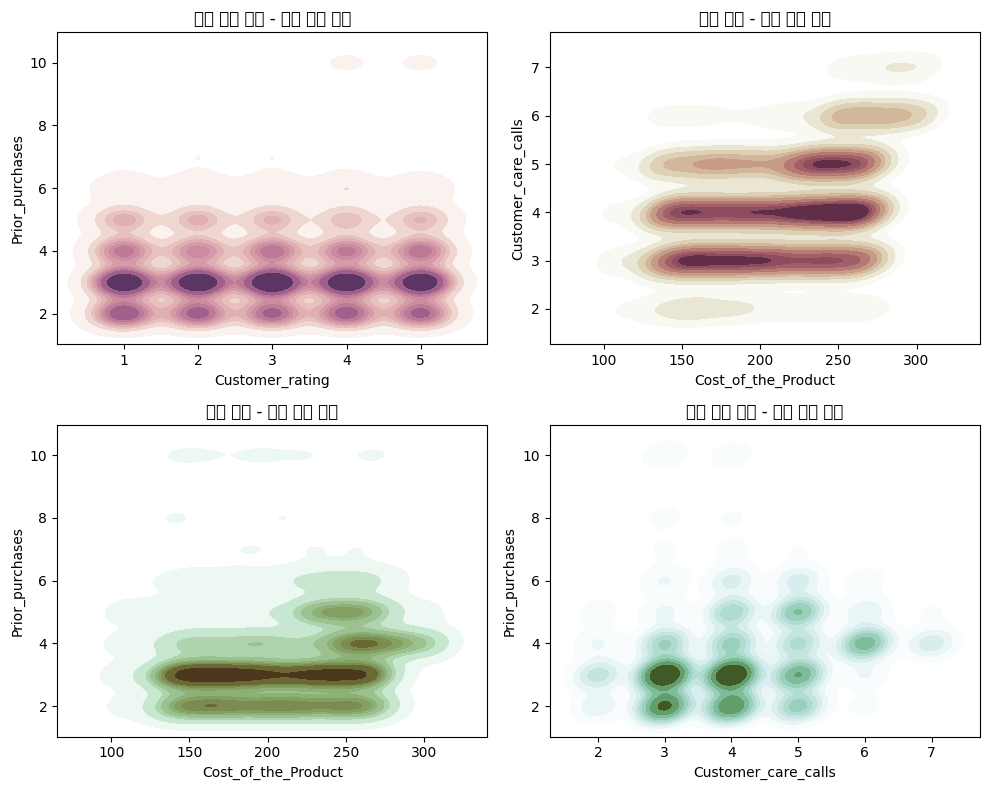

In [9]:
# 여러 개의 KED Plot 생성 준비
f, axes = plt.subplots(2, 2, figsize=(10, 8),
                       sharex=False, sharey=False)
# Plot 색상 설정
s = np.linspace(0, 3, 10)

# 1-1
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
x = train['Customer_rating']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0,0])
axes[0,0].set( title = '고객 만족 점수 - 이전 구매 횟수')

# 1-2
cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Customer_care_calls']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = '상품 비용 - 고객 응답 횟수')

# 2-1
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = '상품 비용 - 이전 구매 횟수')

#2-2
cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
x = train['Customer_care_calls']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = '고객 응답 횟수 - 이전 구매 횟수')

f.tight_layout()



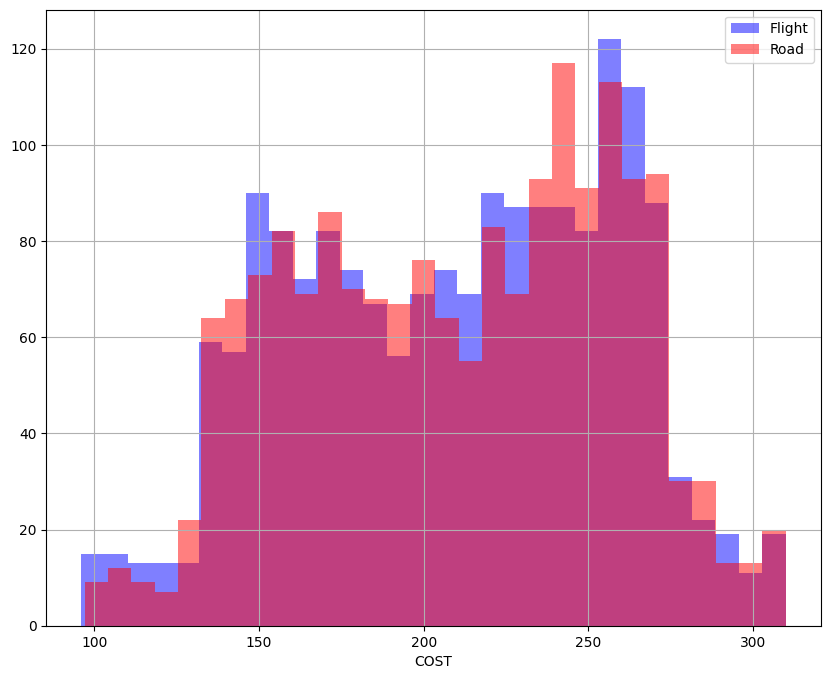

In [10]:
plt.figure(figsize=(10,8))
train[train['Mode_of_Shipment']=='Flight']['Cost_of_the_Product'].hist(alpha=0.5, color='blue', bins=30, label='Flight')
train[train['Mode_of_Shipment']=='Road']['Cost_of_the_Product'].hist(alpha=0.5, color='red', bins=30, label='Road')
plt.xlabel('COST')
plt.legend()

#### 4) 결측값

In [11]:
train.isnull().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Reached.on.Time_Y.N    False
dtype: bool

#### 5) 중복값

In [12]:
# 중복된 항목 수 알아보기
print('중복된 항목 수:', len(train[train.duplicated()]))

중복된 항목 수: 0


### 2. 데이터 전처리

#### 1) 데이터 컬럼명 수정

In [13]:
train = train.rename(columns={'Reached.on.Time_Y.N':'Reached_on_Time_Y_N'})

### 2. Target Feature 정의

#### 1) 데이터 탐색

In [14]:
train.groupby('Reached_on_Time_Y_N').mean()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7090.479486,4.147656,2.967989,214.498647,3.670424,5.545987,4168.668395
1,4424.978364,3.991467,3.005790,207.289197,3.498095,18.663721,3272.640104


In [15]:
train.groupby('Reached_on_Time_Y_N').median()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7096.0,4.0,3.0,222.0,3.0,6.0,4674.0
1,3467.0,4.0,3.0,209.0,3.0,9.0,3231.0


In [16]:
y = train['Reached_on_Time_Y_N'].copy()
y.value_counts()

1    6563
0    4436
Name: Reached_on_Time_Y_N, dtype: int64

#### 2) 숫자형 변수들과의 관계

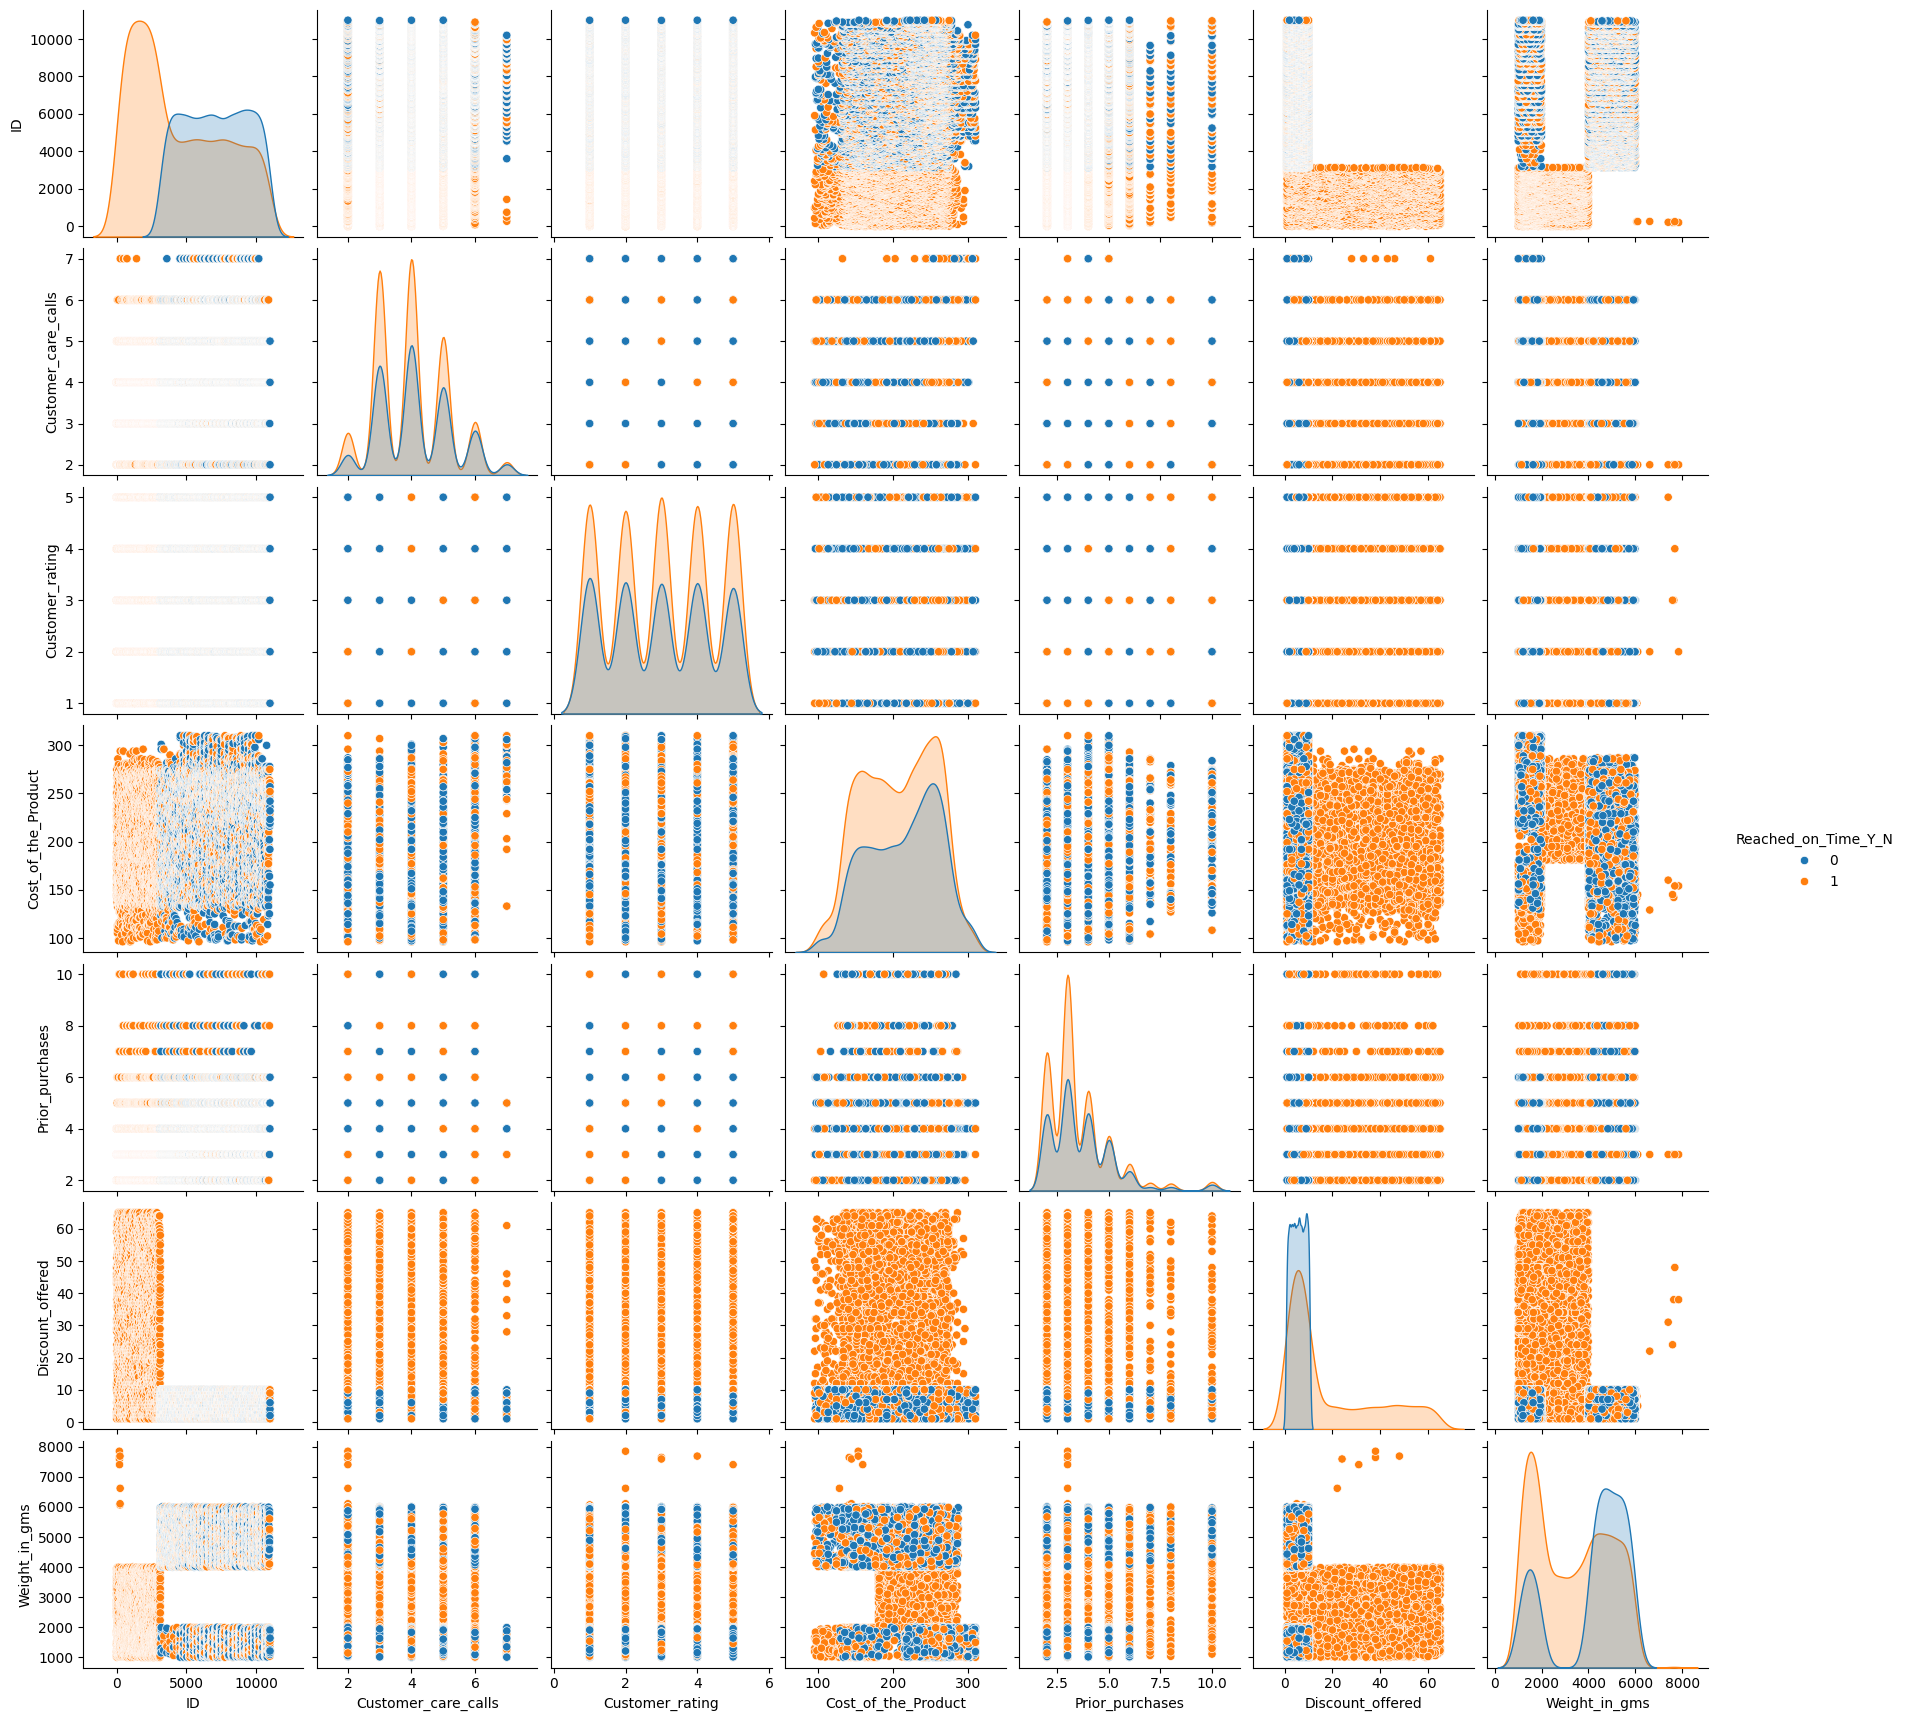

In [17]:
hue='Reached_on_Time_Y_N'
sns.pairplot(train.select_dtypes(include=np.number), hue=hue)
plt.show()

#### 3) 각 변수별 Target Feature 그래프

> 이전 구매횟수 별 Target Feature

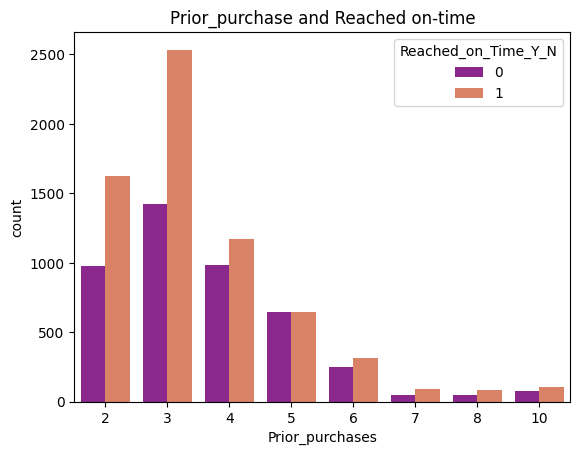

In [18]:
sns.countplot(x='Prior_purchases', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Prior_purchase and Reached on-time')
plt.show()

> 고객 평가 점수별 Target Feature

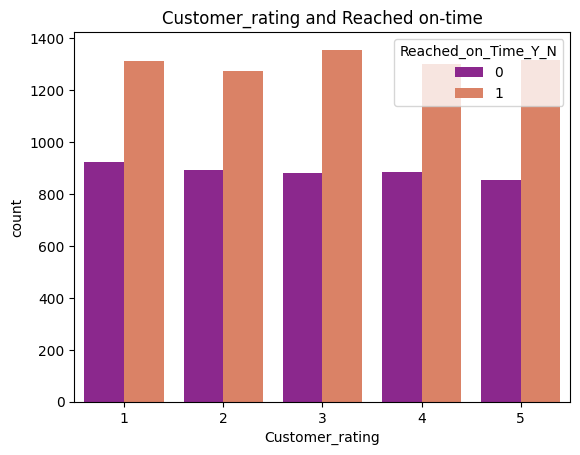

In [19]:
sns.countplot(x='Customer_rating', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Customer_rating and Reached on-time')
plt.show()

> 상품 중요도별 Target Feature

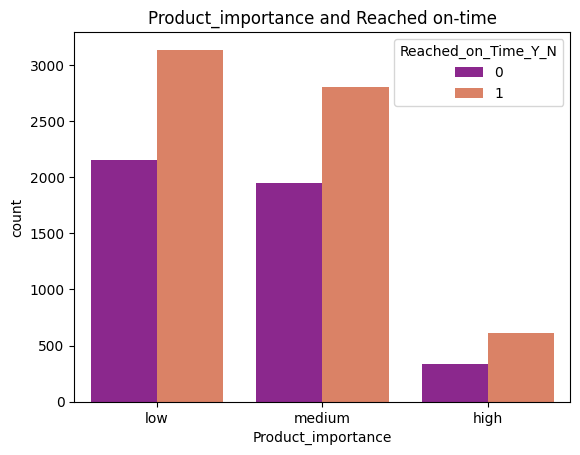

In [20]:
sns.countplot(x='Product_importance', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Product_importance and Reached on-time')
plt.show()

> 성별에 따른 Target Feature

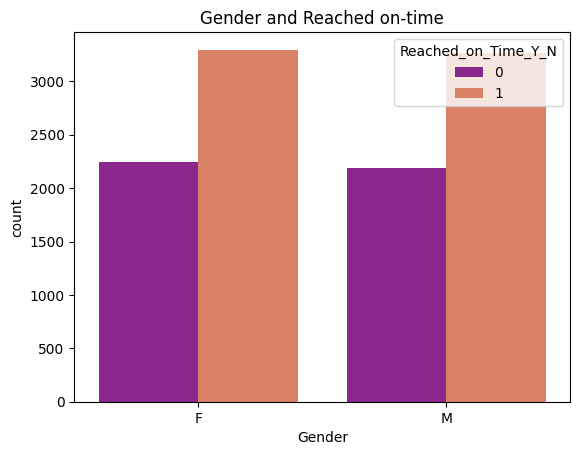

In [21]:
sns.countplot(x='Gender', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Gender and Reached on-time')
plt.show()

> 창고 구역별 Target Feature

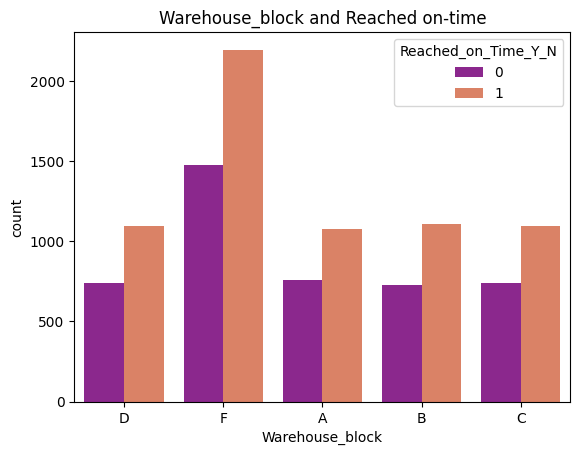

In [22]:
sns.countplot(x='Warehouse_block', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Warehouse_block and Reached on-time')
plt.show()

> 운송 수단별 Target Feature

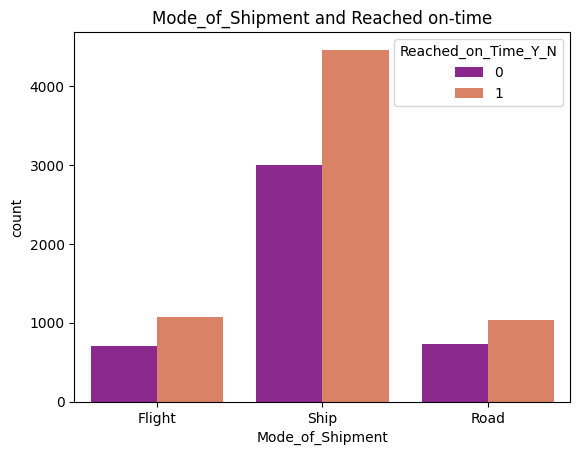

In [23]:
sns.countplot(x='Mode_of_Shipment', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Mode_of_Shipment and Reached on-time')
plt.show()

> 고객 응답 횟수별 Target Feature

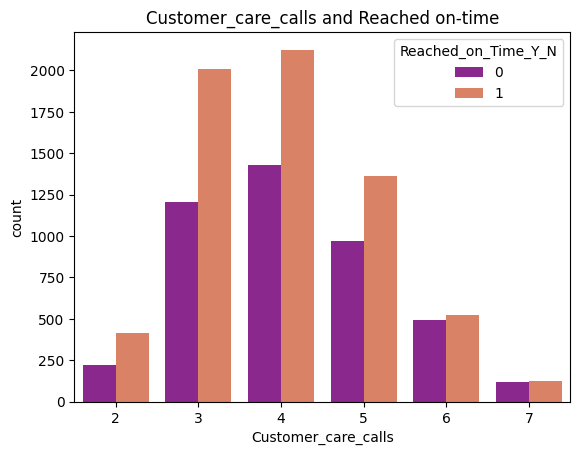

In [24]:
sns.countplot(x='Customer_care_calls', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Customer_care_calls and Reached on-time')
plt.show()

### 4. 데이터 타입별 Feature 변환

#### 1) Feature 탐색

##### 총 Feature 개수 확인

In [25]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_Time_Y_N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


##### Feature 데이터 타입별 개수 확인

In [26]:
# 데이터 타입별 컬럼 수 확인
dtype_data = train.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data = dtype_data.groupby('Column Type').aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64      8
1      object      4


#### 2) 범주형 Feature
* 데이터 확인  
* Feature 별 개수 시각화  
* 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인  
* Feature 별 개수 시각화  
* Feature의 개수가 인코딩에 적합한가?

##### 데이터 확인

In [27]:
# pandas의 select_dtypes 사용
train.select_dtypes(include=['object', 'category']).head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


##### Feature 제거

> Feature 별 유일한 값 개수 확인

In [28]:
cat_feat = train.select_dtypes('object', 'category').columns.values
train_cat = train[cat_feat].copy()
print(train_cat.nunique().sort_values())

Gender                2
Mode_of_Shipment      3
Product_importance    3
Warehouse_block       5
dtype: int64


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다.  
* Target Feature가 포함되어 있으면 함께 제거

##### Feature별 개수 시각화

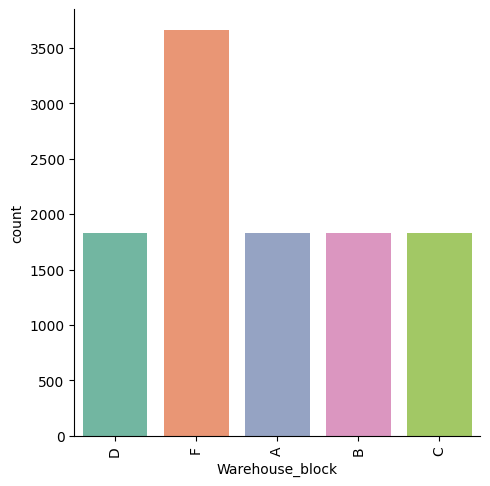

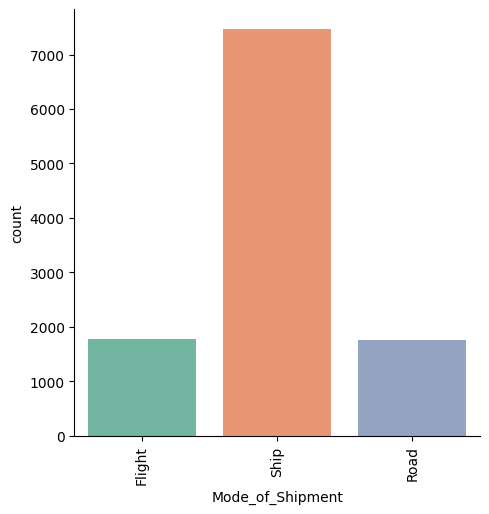

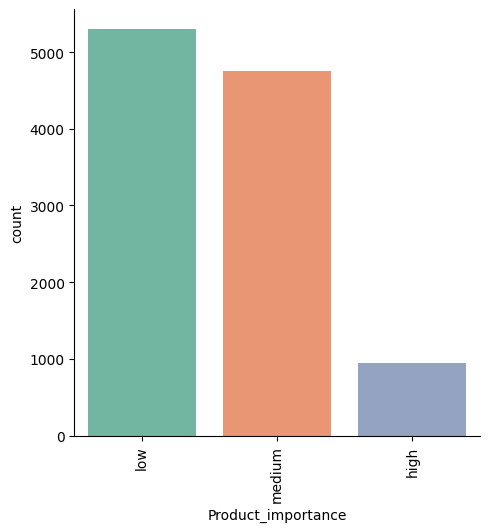

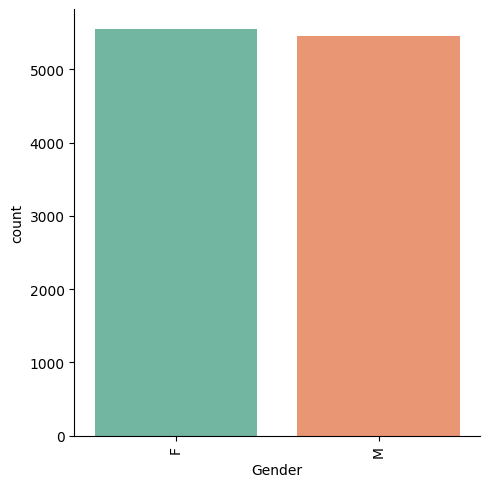

In [29]:
for col in train_cat.columns:
    fig = sns.catplot(x=col, kind='count', data=train_cat, hue=None, palette='Set2')
    fig.set_xticklabels(rotation=90)
    plt.show()

##### Feature의 개수가 인코딩에 적합한가?  
* 인코딩을 했을 경우 메모리 문제가 발생하지는 않는가?

> Feature 인코딩  
* LabelEncoder : LabelEncoder는 선형성을 가지는 머신러닝 기법에 쓰면 좋지 않다.  
* OneHptEncoder vs. get_dummies

In [30]:
# pandas의 get_dummies 활용
train_cat_dummies = pd.get_dummies(train_cat)

train_cat_dummies.head(3)

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1


3) 숫자형 Feature  
* 데이터 확인  
* Feature 제거  
* Feature Skewness 확인

##### 데이터 확인

In [31]:
# pandas의 select_dtypes 사용
train.select_dtypes(include=['number']).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [32]:
train.select_dtypes(include=np.number).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [33]:
num_feat = train.select_dtypes('number').columns.values
train_num = train[num_feat].copy()

##### Feature 제거

In [34]:
print(train_num.nunique().sort_values())

Reached_on_Time_Y_N        2
Customer_rating            5
Customer_care_calls        6
Prior_purchases            8
Discount_offered          65
Cost_of_the_Product      215
Weight_in_gms           4034
ID                     10999
dtype: int64


In [35]:
print(train.shape)

(10999, 12)


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다.  
* Target Feature가 포함되어 있으면 함께 제거.

In [36]:
train_num = train_num.drop(['ID','Reached_on_Time_Y_N'],axis=1, errors='ignore')

##### Feature Skewness 확인

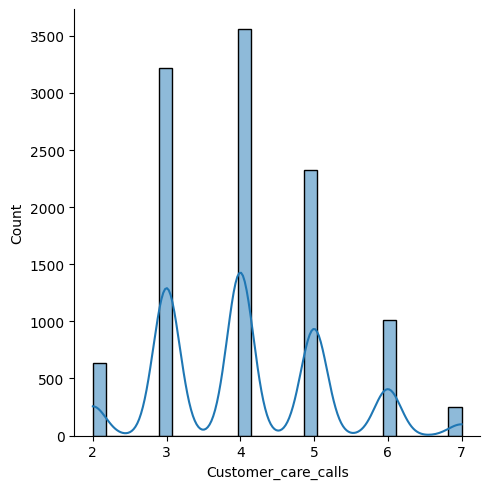

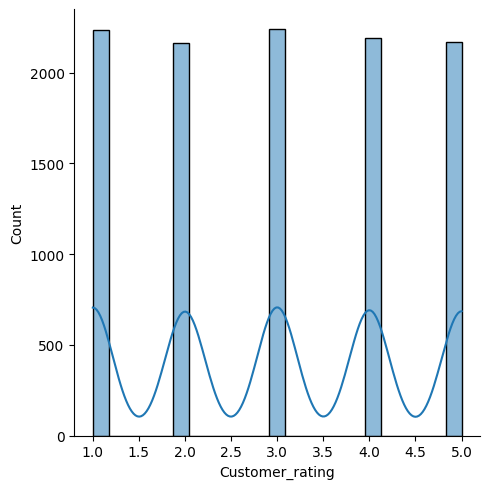

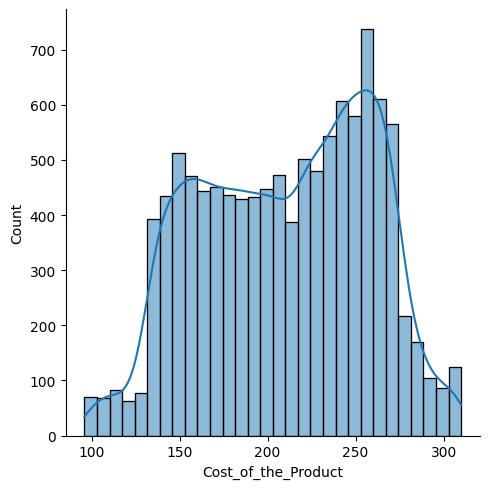

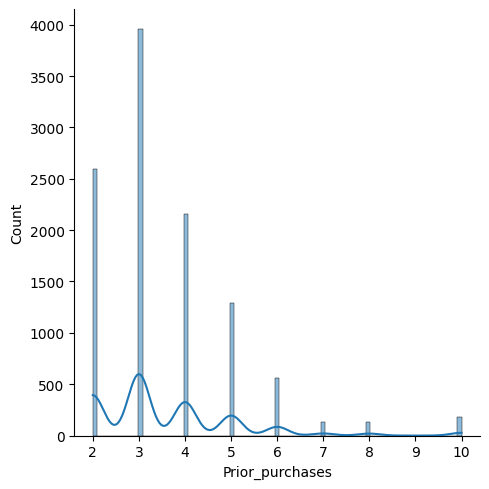

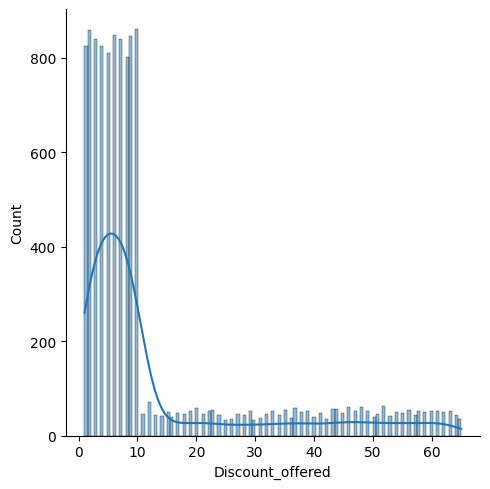

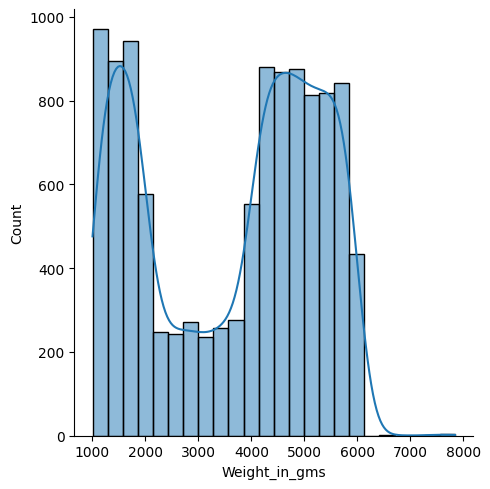

In [37]:
col_attrition_num = train_num.columns.values
for i in range(0, len(col_attrition_num)):
    sns.displot(train_num[col_attrition_num[i]], kde=True)

### 5. 상관성에 따른 Feature 정제

#### 1) 숫자형 Feature  
* 데이터 확인  
* 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다.  
* 상관 계수가 0.9이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다.  
* 컬럼들 간 조합 생성 : comb_num_feat = np.array(list(combination(num_feat, 2)))  
* PearsonR 상관 계수 구하기 : pearsonR(x1, x2)[0]

##### 데이터 확인

In [38]:
train_num.nunique().sort_values()

Customer_rating           5
Customer_care_calls       6
Prior_purchases           8
Discount_offered         65
Cost_of_the_Product     215
Weight_in_gms          4034
dtype: int64

##### 상관계수 구하기

* 방법 1

In [39]:
num_feat = train_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(train_num[comb[0]], train_num[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [40]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([], shape=(0, 2), dtype='<U19')

* 방법 2

In [41]:
# plotly 안 보이는 문제 해결
import plotly.io as pio

pio.renderers.default='colab'
pio.renderers

data = [
    go.Heatmap(
        z=train_num.astype(float).corr().values, # 피어슨 상관계수
        x=train_num.columns.values,
        y=train_num.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity=1.0
    )
]

layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis=dict(ticks='', nticks=36),
    yaxis=dict(ticks=''),
    width=900, height=700,

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

<Axes: >

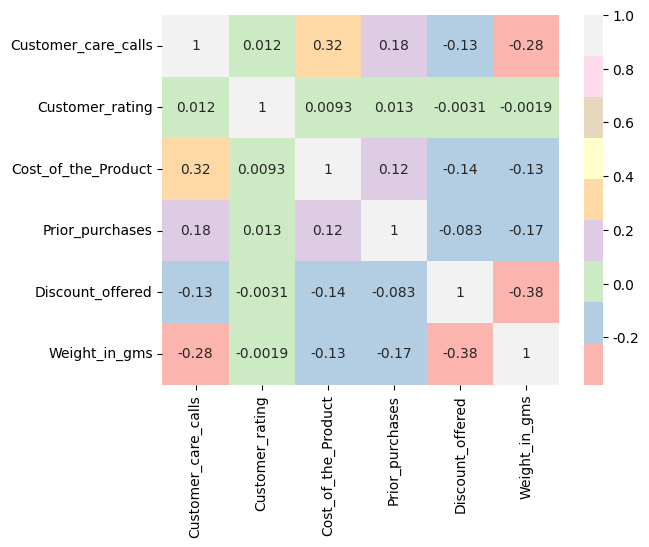

In [42]:
sns.heatmap(train_num.corr(), annot=True, cmap='Pastel1')

#### 2) 범주형 Feature  
* 데이터 확인


##### 데이터 확인  

In [43]:
train_cat_dummies.nunique().sort_values()

Warehouse_block_A            2
Warehouse_block_B            2
Warehouse_block_C            2
Warehouse_block_D            2
Warehouse_block_F            2
Mode_of_Shipment_Flight      2
Mode_of_Shipment_Road        2
Mode_of_Shipment_Ship        2
Product_importance_high      2
Product_importance_low       2
Product_importance_medium    2
Gender_F                     2
Gender_M                     2
dtype: int64

In [44]:
train_cat_dummies.head()

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,1,1,0


In [45]:
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape)-1
  return(stat/(obs*mini))

In [46]:
rows=[]

for var1 in train_cat_dummies:
  col = []
  for var2 in train_cat_dummies:
    cramers =cramers_V(train_cat_dummies[var1], train_cat_dummies[var2]) # Cramer's V test
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns=train_cat_dummies.columns, index=train_cat_dummies.columns)

df

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Warehouse_block_A,1.00,0.04,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_B,0.04,1.00,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_C,0.04,0.04,1.00,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_D,0.04,0.04,0.04,1.00,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_F,0.10,0.10,0.10,0.10,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Flight,0.00,0.00,0.00,0.00,0.0,1.00,0.04,0.41,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Road,0.00,0.00,0.00,0.00,0.0,0.04,1.00,0.40,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Ship,0.00,0.00,0.00,0.00,0.0,0.41,0.40,1.00,0.00,0.00,0.00,0.0,0.0
Product_importance_high,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.09,0.07,0.0,0.0
Product_importance_low,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.09,1.00,0.71,0.0,0.0


In [47]:
np.sum(df>0.9)

Warehouse_block_A            1
Warehouse_block_B            1
Warehouse_block_C            1
Warehouse_block_D            1
Warehouse_block_F            1
Mode_of_Shipment_Flight      1
Mode_of_Shipment_Road        1
Mode_of_Shipment_Ship        1
Product_importance_high      1
Product_importance_low       1
Product_importance_medium    1
Gender_F                     2
Gender_M                     2
dtype: int64

In [48]:
train_final = pd.concat([train['Reached_on_Time_Y_N'], train_num, train_cat_dummies], axis=1)

In [49]:
train_final.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,1,4,2,177,3,44,1233,0,0,0,1,0,1,0,0,0,1,0,1,0
1,1,4,5,216,2,59,3088,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,2,2,183,4,48,3374,1,0,0,0,0,1,0,0,0,1,0,0,1
3,1,3,3,176,4,10,1177,0,1,0,0,0,1,0,0,0,0,1,0,1
4,1,2,2,184,3,46,2484,0,0,1,0,0,1,0,0,0,0,1,1,0


In [50]:
target = train['Reached_on_Time_Y_N']

In [51]:
X = pd.concat([train_num, train_cat_dummies], axis=1)
Y = train['Reached_on_Time_Y_N']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## 03. 예측 분석

#### 고객 정보를 활용한 정시 배송 예측

#### 1) Logistic Regression

##### 모델 생성

In [53]:
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)

##### 모델 평가

In [54]:
print('Accuracy score: {}'.format(accuracy_score(y_test, lr_predictions)))
print('='*60)
print(classification_report(y_test, lr_predictions))

Accuracy score: 0.6239393939393939
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      1379
           1       0.68      0.67      0.68      1921

    accuracy                           0.62      3300
   macro avg       0.61      0.61      0.61      3300
weighted avg       0.62      0.62      0.62      3300



##### RFE(Recursive Feature Elimination) 적용

In [60]:
# Backward
from sklearn.feature_selection import RFE

rfe = RFE(model, n_features_to_select=6)
X_rfe = rfe.fit_transform(X,Y)
model.fit(X_rfe,Y)

print(rfe.support_)
print(rfe.ranking_)
print(X.columns[rfe.support_])

[False False False  True  True False  True False False False False False
 False False False  True  True False  True]
[12  9 13  1  1 14  1  2  8  4  7 10  6 11  3  1  1  5  1]
Index(['Prior_purchases', 'Discount_offered', 'Warehouse_block_A',
       'Product_importance_low', 'Product_importance_medium', 'Gender_M'],
      dtype='object')


##### SelectKBest 적용

In [61]:
# Univariate Selection
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

In [63]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size=0.30)

In [64]:
model=LogisticRegression()
model.fit(X_new_train, y_new_train)
lr_predictions=model.predict(X_new_test)

In [65]:
print('Accuracy score: {}'.format(accuracy_score(y_new_test, lr_predictions)))
print('='*60)
print(classification_report(y_new_test, lr_predictions))

Accuracy score: 0.636969696969697
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      1340
           1       0.70      0.67      0.69      1960

    accuracy                           0.64      3300
   macro avg       0.63      0.63      0.63      3300
weighted avg       0.64      0.64      0.64      3300



#### SVM

##### Feature Scailing

In [67]:
sc_x = StandardScaler()
X_train_sc = sc_x.fit_transform(X_train)
X_test_sc = sc_x.transform(X_test)

##### 모델 생성

In [69]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_sc, y_train)
clf_predictions=clf.predict(X_test_sc)

##### 모델 평가

In [70]:
print('Accuracy score: {}'.format(accuracy_score(y_test, clf_predictions.round(), normalize=True)))
print('='*60)
print(classification_report(y_test, clf_predictions))

Accuracy score: 0.6593939393939394
              precision    recall  f1-score   support

           0       0.57      0.71      0.64      1379
           1       0.75      0.62      0.68      1921

    accuracy                           0.66      3300
   macro avg       0.66      0.67      0.66      3300
weighted avg       0.68      0.66      0.66      3300



##### SelectKBest 적용 후 평가

In [76]:
from sklearn import svm

X_norm = MinMaxScaler().fit_transform(X)
X_new = SelectKBest(chi2, k=6).fit_transform(X_norm, Y)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size=0.30)

clf = svm.SVC(kernel='linear')
clf.fit(X_new_train, y_new_train)
clf_predictions = clf.predict(X_new_test)

print('Accuracy score: {}'.format(accuracy_score(y_new_test, clf_predictions.round(), normalize=True)))
print('='*60)
print(classification_report(y_new_test, clf_predictions))

Accuracy score: 0.66
              precision    recall  f1-score   support

           0       0.57      0.72      0.64      1356
           1       0.76      0.62      0.68      1944

    accuracy                           0.66      3300
   macro avg       0.66      0.67      0.66      3300
weighted avg       0.68      0.66      0.66      3300



#### 3) RandomForest

##### 모델 생성

In [77]:
rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [78]:
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.656060606060606


##### Feature Importances

<Axes: xlabel='Importance', ylabel='Feature'>

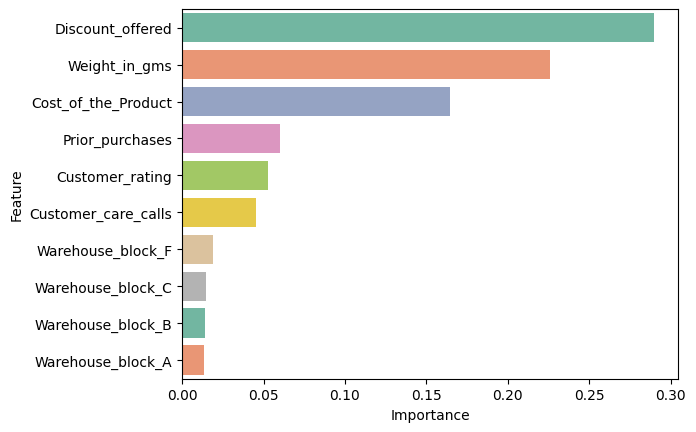

In [82]:
feat = X.columns.values
imp = rf.feature_importances_

df = pd.DataFrame({'Feature': feat, 'Importance':imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df, palette='Set2')

In [80]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x = X.columns.values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale=True
    ),
    text = X.columns.values
)

data = [trace]

layout = go.Layout(
    autosize=True,
    title = 'Random Forest Feature Importance',
    hovermode='closest',
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

##### RFE(Recursive Feature Elimination) 적용

In [84]:
rfe = RFE(rf, n_features_to_select=6)

# Transforming data using RFE

X_rfe = rfe.fit_transform(X, Y)

# Fitting the data to model
rf.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False False False False False
 False False False False False False False]
[ 1  1  1  1  1  1  8  7  6 10  4 11 12  5 14  3  9  2 13]


##### SelectKBest 적용 후 평가

In [85]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train, X_new_test, y_new_train, y_new_test=train_test_split(X_new, Y, test_size=0.30)

rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_new_train, y_new_train)
y_pred = rf.predict(X_new_test)

print('accuracy score: {}'.format(accuracy_score(y_new_test, y_pred.round())))

accuracy score: 0.6609090909090909


#### 4) XGBoost


##### 모델 생성

In [86]:
xgmodel = XGBClassifier()
xgmodel.fit(X_train, y_train)
y_pred = xgmodel.predict(X_test)

In [87]:
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.6509090909090909


##### RFE(Recursive Feature Elimination) 적용

In [88]:
rfe = RFE(xgmodel, n_features_to_select=6)

# Transforming data using RFE

X_rfe = rfe.fit_transform(X, Y)

# Fitting the data to model
xgmodel.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True  True False False False False False
  True False False False False False False]
[ 5  8  1  1  1  1  1  6  3  7  4  2  1 10 11 12 13  9 14]


##### SelectKBest 적용 후 평가

In [89]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train, X_new_test, y_new_train, y_new_test=train_test_split(X_new, Y, test_size=0.30)

xgmode=XGBClassifier()
xgmode.fit(X_new_train, y_new_train)
y_pred = xgmode.predict(X_new_test)

print('Accuracy score: {}'.format(accuracy_score(y_new_test, y_pred.round())))

Accuracy score: 0.6518181818181819


## 04. 군집 분석

#### 군집 분석을 활용한 고객 Segmentation

#### 1) K-Means Clustering

##### Elbow 방법 적용

In [90]:
clustdata = train_final[(train_final.Reached_on_Time_Y_N == 1)]

In [91]:
wcss = []

for i in range(1, 15):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
  kmeans.fit(clustdata)
  wcss.append(kmeans.inertia_)

WCSS는 클러스터의 각 구성원과 중심 사이의 거리 제곱의 합임.

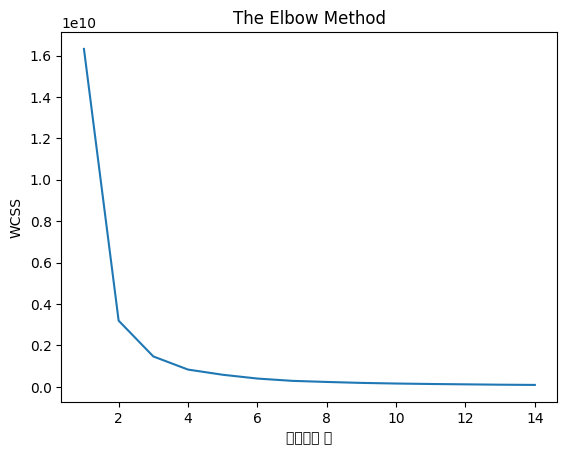

In [92]:
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('클러스터 수')
plt.ylabel('WCSS')
plt.show()

In [93]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10)
c = km.fit_predict(clustdata)
c

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [94]:
clustdata['Cluster']=c
clustdata.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,...,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,Cluster
0,1,4,2,177,3,44,1233,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,1,4,5,216,2,59,3088,0,0,0,...,1,1,0,0,0,1,0,0,1,1
2,1,2,2,183,4,48,3374,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,1,3,3,176,4,10,1177,0,1,0,...,0,1,0,0,0,0,1,0,1,1
4,1,2,2,184,3,46,2484,0,0,1,...,0,1,0,0,0,0,1,1,0,1


In [95]:
clustdata.groupby(['Cluster']).mean()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Cluster,,,,,,,,,,,,,,,,,,,,
0,1.0,3.821617,3.020749,208.292970,3.354289,11.154227,4709.394240,0.162589,0.167234,0.166925,0.169712,0.333540,0.169712,0.156705,0.673583,0.109631,0.443791,0.446578,0.492722,0.507278
1,1.0,4.155969,2.991302,206.317037,3.637373,25.936713,1881.134673,0.164967,0.169166,0.166467,0.164367,0.335033,0.156269,0.158668,0.685063,0.078584,0.511998,0.409418,0.511398,0.488602


##### 군집화된 데이터 Scailing

In [96]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustdata)

X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

##### PCA 적용 (n=2)

In [97]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1','P2']

In [98]:
c1 = km.fit_predict(X_principal)
c1

array([0, 1, 1, ..., 0, 1, 0], dtype=int32)

In [100]:
result=pd.DataFrame({'P1' : X_principal.iloc[:,0] ,'P2' : X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c1, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511946,-0.227402,0
1,-0.314657,0.373822,1
2,-0.002551,0.293362,1
3,-0.107707,0.220330,1
4,-0.194866,-0.368205,0


##### 주성분-클러스터 그래프

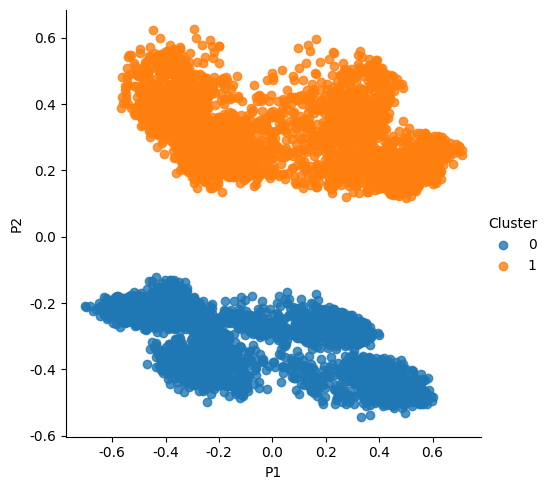

In [103]:
import seaborn as sns
facet = sns.lmplot(data=result, x='P1', y='P2', hue='Cluster', fit_reg=False, legend=True, legend_out=True)

In [104]:
result['Cluster'].value_counts()

0    3296
1    3267
Name: Cluster, dtype: int64

##### PCA 후 Elbow 방법 적용

In [105]:
wcss=[]

for i in range(2, 15):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
  kmeans.fit(X_principal)
  wcss.append(kmeans.inertia_)

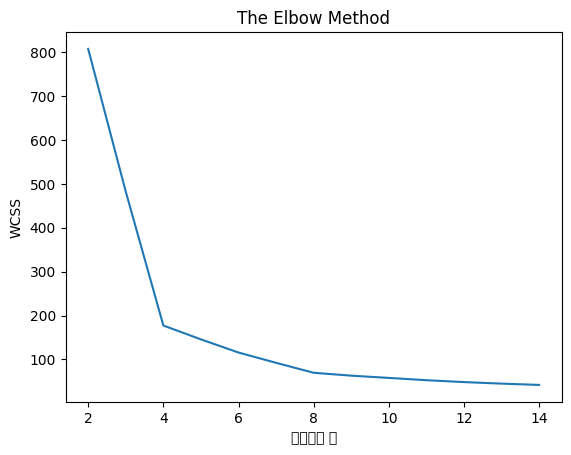

In [106]:
plt.plot(range(2, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('클러스터 수')
plt.ylabel('WCSS')
plt.show()

In [107]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, init='k-means++', n_init=10)
c = km.fit_predict(X_principal)
c

array([0, 2, 2, ..., 0, 2, 0], dtype=int32)

In [108]:
result = pd.DataFrame({'P1':X_principal.iloc[:,0], 'P2':X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511946,-0.227402,0
1,-0.314657,0.373822,2
2,-0.002551,0.293362,2
3,-0.107707,0.220330,2
4,-0.194866,-0.368205,0


##### 새로운 주성분-클러스터 그래프

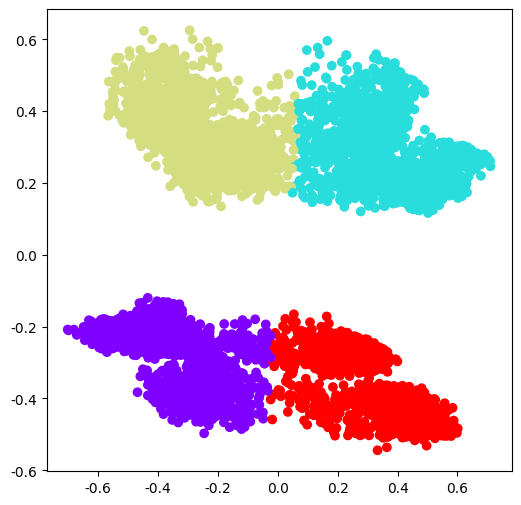

In [109]:
# Visualizing the clustering
plt.figure(figsize=(6,6))
plt.scatter(result.iloc[:,0], result.iloc[:,1],c=result['Cluster'], cmap='rainbow')
plt.show()

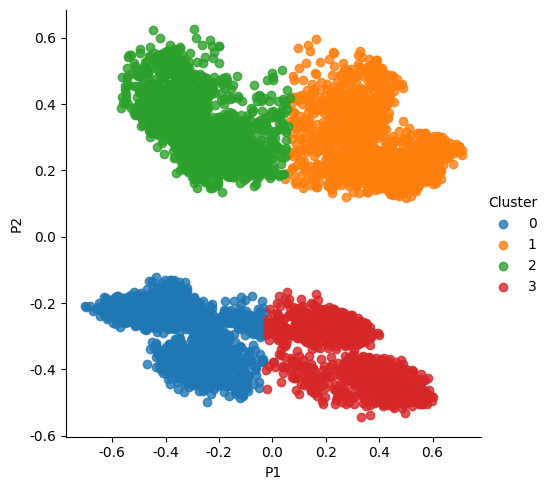

In [110]:
facet = sns.lmplot(data=result, x='P1', y='P2', hue='Cluster', fit_reg=False, legend=True, legend_out=True)